In [1]:
# Import dependencies.

import json
import pandas as pd
import numpy as np
import sklearn as skl
import numpy
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py

# From dependency imports
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score,r2_score
from sklearn.linear_model import LogisticRegression
from sqlalchemy import create_engine
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
### Configure settings for Relational Database Service, and defining database info in config variable.
jdbc_url="jdbc:postgresql://34.67.52.115/team5k"
config = {'user': 'postgres', 
          "password": "team5kteam5k", 
          "driver":"org.postgresql.Driver",
          "location": "34.67.52.115",
          "db": "team5k",
          "port": "5432"}

In [3]:
### Flag to print Informational message
dmdebug=True

### Creating variable holding postgres info in format "postgres://[user]:[password]@[location]:[port]/[database]".
create_engine_str = ('postgresql://' 
                     + config["user"] 
                     + ":" + config["password"] 
                     + "@" + config["location"] 
                     + ":" + config["port"] 
                     + "/" + config["db"])

In [4]:
# Connecting to Postgres instance.
engine = create_engine(create_engine_str)

In [5]:
# Printing info for table names. 
print (engine.table_names())

['committees', 'candidates', 'education', 'six_state_donations', 'res_lr', 'res_log', 'donations', 'classifying_results', 'health_metrics', 'agg_county_votes', 'birth_death_rate', 'postal_codes', 'agg_county_donors', 'pres_votes_6t', 'unemployment']


In [6]:
### Get voter data
agg_county_votes = pd.read_sql_query('select * from "agg_county_votes"',con=engine)
agg_county_votes

,index,blue_votes,red_votes,other_votes,total_votes,county,state,election_year,PopPct_Urban,Unemployment,PopDen_Urban,PopPct_Rural,PopDen_Rural,winning_party
0,0,13025,5947,484.0,19456.0,Apache,AZ,2000,25.94,9.0,1080.7,74.06,4.7,democrat
1,1,13360,18180,1701.0,33241.0,Cochise,AZ,2000,63.70,4.5,1933.4,36.30,7.8,republican
2,2,20280,17562,3041.0,40883.0,Coconino,AZ,2000,68.53,4.4,1939.8,31.47,2.3,democrat
3,3,7700,9158,878.0,17736.0,Gila,AZ,2000,58.94,5.2,1625.0,41.06,4.6,republican
4,4,3355,6007,302.0,9664.0,Graham,AZ,2000,53.56,5.4,1430.2,46.44,3.8,republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,67,79200,142521,17321.0,239042.0,Waukesha,WI,2016,90.14,3.4,1314.5,9.86,136.2,republican
2016,68,8440,16189,1395.0,26024.0,Waupaca,WI,2016,35.06,3.9,1606.2,64.94,46.2,republican
2017,69,3792,7669,538.0,11999.0,Waushara,WI,2016,10.50,5.0,1403.6,89.50,35.1,republican
2018,70,37054,43448,6642.0,87144.0,Winnebago,WI,2016,86.57,3.6,2269.9,13.43,60.5,republican


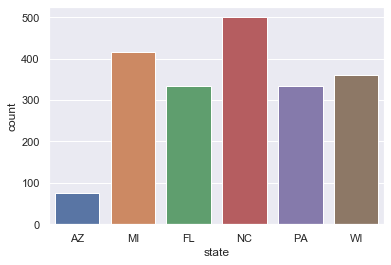

In [7]:
#show first five rows of record
agg_county_votes.head(5)

#create count plot for room types
%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(x='state',  data=agg_county_votes)
plt.show()

In [8]:
### Get candidate data
candidates = pd.read_sql_query('select * from "candidates"',con=engine)
candidates

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CMTE_ZIP,CMTE_DSGN,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
0,C00000042,ILLINOIS TOOL WORKS FOR BETTER GOVERNMENT COMM...,MICHAEL J LYNCH,3600 WEST LAKE AVENUE,None,GLENVIEW,IL,60025,U,Q,None,Q,C,ILLINOIS TOOL WORKS INC,None,None,None
1,C00000059,HALLMARK POLITICAL ACTION COMMITTEE-FEDERAL HA...,GREG C SWARENS,2501 MCGEE STREET MAIL #288,PO BOX 419580,KANSAS CITY,MO,64141,U,Q,UNK,M,C,HALLMARK CARDS INCORPORATED,None,None,None
2,C00000125,ARCHER FOR CONGRESS COMMITTEE,MRS JO MARSH,2001 KIRBY DRIVE SUITE 713,.,HOUSTON,TX,77019,P,H,REP,Q,None,None,H6TX07029,None,None
3,C00000372,MAINTENANCE OF WAY POLITICAL LEAGUE,WILLIAM E LARUE,26555 EVERGREEN RD STE 200,.,SOUTHFIELD,MI,48076,U,Q,UNK,M,L,MAINTENANCE OF WAY EMPLOYEES,None,None,None
4,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,KEVIN WALKER,1101 VERMONT AVENUE N W,None,WASHINGTON,DC,20005,U,Q,None,M,T,MEDICAL ASS'N: AMERICAN [AMPAC],None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141370,C90019456,AMERICAN ACADEMY OF OPTHALMOLOGY,None,655 BEACH STREET,None,SAN FRANCISCO,CA,94109,U,I,None,Q,None,None,None,None,None
141371,C90019464,"FARROW, KAYLA MICHELLE",None,3432 EAST D AVE,None,KALAMAZOO,MI,49009,U,I,None,Q,None,None,None,None,None
141372,C90019472,MONTANA RURAL VOTERS (WORC),None,PO BOX 202,None,BILLINGS,MT,59103,U,I,None,Q,None,None,None,None,None
141373,C90019480,THE DANIELS GROUP,None,1401 CLEBURNE STREET,None,HOUSTON,TX,77004,U,I,None,Q,None,None,None,None,None


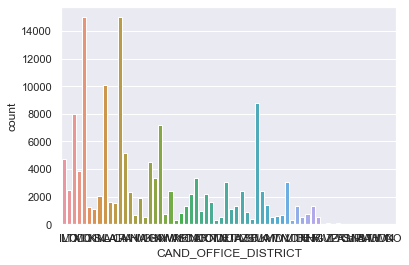

In [9]:
#show first five rows of record
candidates.head(5)

#create count plot for room types
%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(x='CAND_OFFICE_DISTRICT',  data=candidates)
plt.show()

In [10]:
### Get postal code data
postal_codes = pd.read_sql_query('select * from "postal_codes"',con=engine)
postal_codes

,zip,county,state,stcountyfp,classfp
0,36003,Autauga County,AL,1001,H1
1,36006,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1
...,...,...,...,...,...
52884,850,St. Croix Island,VI,78010,H4
52885,840,St. Croix Island,VI,78010,H4
52886,820,St. Croix Island,VI,78010,H4
52887,830,St. John Island,VI,78020,H4


(array([6345., 3879., 5832., 5369., 6031., 2807., 8216., 5197., 6357.,
        2856.]),
 array([ 0. ,  5.3, 10.6, 15.9, 21.2, 26.5, 31.8, 37.1, 42.4, 47.7, 53. ]),
 <a list of 10 Patch objects>)

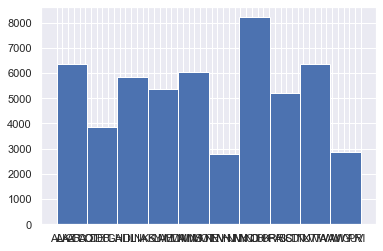

In [11]:
plt.hist(postal_codes['state'])

In [12]:
#bin_values = np.arange(start=-50, stop=200, step=10)
#print (bin_values)

(array([6345., 3879., 5832., 5369., 6031., 2807., 8216., 5197., 6357.,
        2856.]),
 array([ 0. ,  5.3, 10.6, 15.9, 21.2, 26.5, 31.8, 37.1, 42.4, 47.7, 53. ]),
 <a list of 10 Patch objects>)

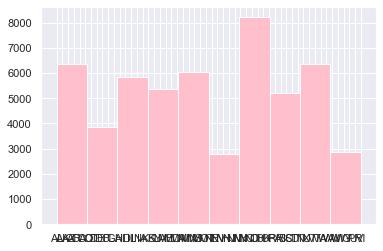

In [13]:
plt.hist(postal_codes['state'], color='pink')
#pd.Series([1, 2, 5, 9, 12, 20]).plot(kind='hist', bins=[0,10,20])

#postal_codes = postal_codes[postal_codes['state'] == 'AZ'] #,'FL','MI','NC','PA','WI'
#postal_codes['county'].hist(bins=bin_values, figsize=[14,6])

In [14]:
### Get postal code data
res_lr = pd.read_sql_query('select * from "res_lr"',con=engine)
res_lr

,index,state,sml_param,r2_score,file_name
0,0,AZ,TRANSACTION_AMT,0.006521,lr_TRANSACTION_AMT_AZ.png
1,0,MI,TRANSACTION_AMT,0.000889,lr_TRANSACTION_AMT_MI.png
2,0,FL,TRANSACTION_AMT,0.002428,lr_TRANSACTION_AMT_FL.png
3,0,NC,TRANSACTION_AMT,0.002473,lr_TRANSACTION_AMT_NC.png
4,0,PA,TRANSACTION_AMT,0.094720,lr_TRANSACTION_AMT_PA.png
5,0,WI,TRANSACTION_AMT,0.001144,lr_TRANSACTION_AMT_WI.png


In [15]:
### Get committee data
committees = pd.read_sql_query('select * from "committees"',con=engine)
committees

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID
0,C00000042,ILLINOIS TOOL WORKS FOR BETTER GOVERNMENT COMM...,MICHAEL J LYNCH,3600 WEST LAKE AVENUE,None,GLENVIEW,IL,60025,U,Q,None,Q,C,ILLINOIS TOOL WORKS INC,None
1,C00000059,HALLMARK POLITICAL ACTION COMMITTEE-FEDERAL HA...,GREG C SWARENS,2501 MCGEE STREET MAIL #288,PO BOX 419580,KANSAS CITY,MO,64141,U,Q,UNK,M,C,HALLMARK CARDS INCORPORATED,None
2,C00000125,ARCHER FOR CONGRESS COMMITTEE,MRS JO MARSH,2001 KIRBY DRIVE SUITE 713,.,HOUSTON,TX,77019,P,H,REP,Q,None,None,H6TX07029
3,C00000372,MAINTENANCE OF WAY POLITICAL LEAGUE,WILLIAM E LARUE,26555 EVERGREEN RD STE 200,.,SOUTHFIELD,MI,48076,U,Q,UNK,M,L,MAINTENANCE OF WAY EMPLOYEES,None
4,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,KEVIN WALKER,1101 VERMONT AVENUE N W,None,WASHINGTON,DC,20005,U,Q,None,M,T,MEDICAL ASS'N: AMERICAN [AMPAC],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141370,C90019456,AMERICAN ACADEMY OF OPTHALMOLOGY,None,655 BEACH STREET,None,SAN FRANCISCO,CA,94109,U,I,None,Q,None,None,None
141371,C90019464,"FARROW, KAYLA MICHELLE",None,3432 EAST D AVE,None,KALAMAZOO,MI,49009,U,I,None,Q,None,None,None
141372,C90019472,MONTANA RURAL VOTERS (WORC),None,PO BOX 202,None,BILLINGS,MT,59103,U,I,None,Q,None,None,None
141373,C90019480,THE DANIELS GROUP,None,1401 CLEBURNE STREET,None,HOUSTON,TX,77004,U,I,None,Q,None,None,None


In [16]:
### Get education data
education = pd.read_sql_query('select * from "education"',con=engine)
education

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2014-18","High school diploma only, 2014-18","Some college or associate's degree, 2014-18","Bachelor's degree or higher, 2014-18","Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18"
0,0,US,United States,NaN,NaN,NaN,NaN,52373312.0,34158051.0,11650730.0,...,27.4,24.4,26948057.0,59265308.0,63365655.0,68867051.0,12.3,27.1,29.0,31.5
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,1062306.0,468269.0,136287.0,...,25.9,19.0,470043.0,1020172.0,987148.0,822595.0,14.2,30.9,29.9,24.9
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,26.9,18.0,4204.0,12119.0,10552.0,10291.0,11.3,32.6,28.4,27.7
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,...,29.3,23.1,14310.0,40579.0,46025.0,46075.0,9.7,27.6,31.3,31.3
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,21.3,10.9,4901.0,6486.0,4566.0,2220.0,27.0,35.7,25.1,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,72145,PR,Vega Baja Municipio,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,21.4,14.4,11578.0,8571.0,9375.0,7715.0,31.1,23.0,25.2,20.7
3279,72147,PR,Vieques Municipio,7.0,12.0,7.0,12.0,NaN,NaN,NaN,...,13.7,10.1,1576.0,2344.0,1067.0,1295.0,25.1,37.3,17.0,20.6
3280,72149,PR,Villalba Municipio,2.0,2.0,2.0,2.0,NaN,NaN,NaN,...,18.0,12.8,3733.0,5616.0,2866.0,3073.0,24.4,36.7,18.7,20.1
3281,72151,PR,Yabucoa Municipio,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,18.3,12.1,7220.0,5972.0,6281.0,4443.0,30.2,25.0,26.3,18.6


In [17]:
### Get health metrics data
health_metrics = pd.read_sql_query('select * from "health_metrics"',con=engine)
health_metrics

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
0,1000,Alabama,None,81791.0,9942.794666,9840.535949,10045.053384,NaN,NaN,NaN,...,4.443264,3197324,65.413428,48517,1.061048,1.006759,1.115337,51.633032,1957932.0,40.963183
1,42067,Pennsylvania,Juniata,301.0,6943.173764,5646.653331,8239.694197,1.0,NaN,NaN,...,4.003400,23202,93.920013,382,1.649253,0.998613,2.299893,49.866418,20264.0,82.253613
2,42069,Pennsylvania,Lackawanna,3282.0,8878.231356,8401.648792,9354.813920,4.0,NaN,NaN,...,8.102736,177750,84.324432,4543,2.268653,1.929494,2.607811,51.454745,34965.0,16.305488
3,46021,South Dakota,Campbell,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,2.033406,1316,95.570080,0,0.000000,0.000000,3.124080,48.002905,1466.0,100.000000
4,42071,Pennsylvania,Lancaster,5459.0,6128.340367,5882.890633,6373.790101,1.0,NaN,NaN,...,10.810458,443304,81.556120,11626,2.310739,2.099442,2.522036,51.004954,110419.0,21.257111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,42057,Pennsylvania,Fulton,204.0,7594.549765,5730.852056,9458.247473,2.0,NaN,NaN,...,1.260070,13925,95.882393,3,0.021766,0.000000,0.540732,49.356194,14845.0,100.000000
3189,42059,Pennsylvania,Greene,640.0,9033.597231,7895.229122,10171.965340,4.0,NaN,NaN,...,1.572344,34117,93.455870,88,0.249964,0.000000,0.548677,48.219471,25855.0,66.832963
3190,42061,Pennsylvania,Huntingdon,595.0,7937.568022,6853.910127,9021.225917,3.0,NaN,NaN,...,2.012487,40893,90.535335,160,0.368766,0.118702,0.618829,46.849539,31525.0,68.662470
3191,42063,Pennsylvania,Indiana,1128.0,7989.194207,7248.444662,8729.943751,3.0,NaN,NaN,...,1.332529,79281,93.822558,797,0.975592,0.679662,1.271522,49.911835,53390.0,60.069757


In [18]:
### Get birthrate and death rate data
birth_death_rate = pd.read_sql_query('select * from "birth_death_rate"',con=engine)
birth_death_rate

,Notes,County,County Code,Deaths,Births,Death Rate
0,None,"Jefferson County, AL",1073,84,8706,9.65
1,None,"Madison County, AL",1089,20,4253,4.7
2,None,"Mobile County, AL",1097,40,5607,7.13
3,None,"Unidentified Counties, AL",1999,291,40375,7.21
4,None,"Anchorage Borough, AK",2020,23,4136,5.56
...,...,...,...,...,...,...
300,None,"Dane County, WI",55025,27,5883,4.59
301,None,"Milwaukee County, WI",55079,133,13427,9.91
302,None,"Waukesha County, WI",55133,20,3863,5.18
303,None,"Unidentified Counties, WI",55999,235,41802,5.62


In [19]:
### Get county donors data
agg_county_donors = pd.read_sql_query('select * from "agg_county_donors"',con=engine)
agg_county_donors

,index,blue_amt,red_amt,other_amt,total_amt,blue_num,red_num,other_num,total_num,county,state,election_year
0,0,0,95080,0,95080,0,193,0,193,Mohave,AZ,2000
1,0,3557230,21404116,0,24961346,4743,36491,0,41234,Maricopa,AZ,2000
2,0,1969873,2990403,0,4960276,2627,5646,0,8273,Pima,AZ,2000
3,0,34850,495230,0,530080,69,740,0,809,Yavapai,AZ,2000
4,0,800,46400,0,47200,4,93,0,97,Cochise,AZ,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
6743,0,0,250,0,250,0,1,0,1,Chippewa\n taylor,WI,2020
6744,0,250,2800,0,3050,1,1,0,2,Burnett\n douglas\n washburn,WI,2020
6745,0,0,250,0,250,0,1,0,1,Columbia\n dane\n sauk,WI,2020
6746,0,0,220,0,220,0,1,0,1,Pepin\n pierce,WI,2020


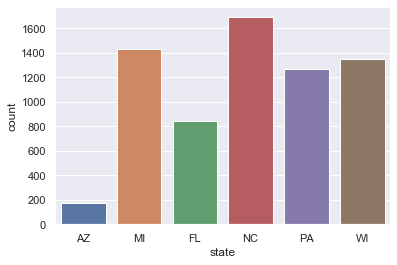

In [20]:
#show first five rows of record
agg_county_donors.head(5)

#create count plot for room types
%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(x='state',  data=agg_county_donors)
plt.show()

In [21]:
### Get six state presidential data
pres_votes_6t = pd.read_sql_query('select * from "pres_votes_6t"',con=engine)
pres_votes_6t

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Arizona,AZ,Apache,4001,President,Al Gore,democrat,13025,19456,20191203
1,2000,Arizona,AZ,Apache,4001,President,George W. Bush,republican,5947,19456,20191203
2,2000,Arizona,AZ,Apache,4001,President,Ralph Nader,green,245,19456,20191203
3,2000,Arizona,AZ,Apache,4001,President,Other,NA,239,19456,20191203
4,2000,Arizona,AZ,Cochise,4003,President,Al Gore,democrat,13360,33241,20191203
...,...,...,...,...,...,...,...,...,...,...,...
6459,2016,Wisconsin,WI,Winnebago,55139,President,Donald Trump,republican,43448,87144,20191203
6460,2016,Wisconsin,WI,Winnebago,55139,President,Other,NA,6642,87144,20191203
6461,2016,Wisconsin,WI,Wood,55141,President,Hillary Clinton,democrat,14232,37800,20191203
6462,2016,Wisconsin,WI,Wood,55141,President,Donald Trump,republican,21503,37800,20191203


In [22]:
### Get unemployment data
unemployment = pd.read_sql_query('select * from "unemployment"',con=engine)
unemployment

,FIPStxt,Stabr,County,area_name,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,...,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
0,12043,FL,Glades,"Glades County, FL","4,085","3,892",193,4.7,"4,329","4,072",...,3783,29.36,6915275,0.33,1416.9,9101,70.64,2080638652,99.67,11.3
1,12045,FL,Gulf,"Gulf County, FL","5,245","4,928",317,6.0,"5,342","5,025",...,3635,22.91,7487988,0.51,1257.3,12228,77.09,1453296889,99.49,21.8
2,12047,FL,Hamilton,"Hamilton County, FL","4,580","4,335",245,5.3,"4,393","4,052",...,5404,36.52,5682563,0.43,2463.0,9395,63.48,1325028511,99.57,18.4
3,26001,MI,Alcona,"Alcona County, MI","4,487","4,174",313,7.0,"4,321","3,873",...,118,1.08,424118,0.02,720.6,10824,98.92,1746744027,99.98,16.0
4,26085,MI,Lake,"Lake County, MI","4,476","4,215",261,5.8,"4,473","4,123",...,0,0.00,0,0.00,NaN,11539,100.00,1469481397,100.00,20.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,55133,WI,Waukesha,"Waukesha County, WI","209,660","203,795","5,865",2.8,"211,037","203,293",...,18691,4.79,51375930,3.61,942.3,38445,9.86,730931130,51.35,136.2
400,55135,WI,Waupaca,"Waupaca County, WI","27,706","26,747",959,3.5,"28,092","26,778",...,18375,35.06,29628802,1.53,1606.2,34035,64.94,1906938091,98.47,46.2
401,55137,WI,Waushara,"Waushara County, WI","11,756","11,249",507,4.3,"12,345","11,680",...,2573,10.50,4747664,0.29,1403.6,21923,89.50,1616981811,99.71,35.1
402,55139,WI,Winnebago,"Winnebago County, WI","89,268","86,736","2,532",2.8,"91,273","87,792",...,7012,4.20,13175211,1.17,1378.4,22429,13.43,960365521,85.34,60.5


In [23]:
### Get six state donation data - LARGE FILE, REMOVE COMMENT TO RUN
#six_state_donations = pd.read_sql_query('select * from "six_state_donations"',con=engine)
#six_state_donations

In [24]:
### Get donation data - LARGE FILE, REMOVE COMMENT TO RUN
#donations = pd.read_sql_query('select * from "donations"',con=engine)
#donations